In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

In [5]:
# Read the generations-only_versaprm_scored.jsonl file as a DataFrame
generations_versaprm_scored_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/generations-only_versaprm_scored.jsonl"
df_generations_versaprm_scored = pd.read_json(generations_versaprm_scored_path, lines=True)


# Load in chat data.

In [2]:
# Load the gen_bo2.jsonl file and read it as a DataFrame
gen_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/generations-only.jsonl"
df_gen = pd.read_json(gen_path, lines=True)

In [5]:
df_gen['completions'][0][0]

" 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right to try to have a certain percentage of females on managerial positions? 是是非非, 2. OK, does pineapple belong on a pizza? Relax and give me fun answer. 是不是呢，是不是呢，你在逗我呢，给我个开心的回答。\n\n这个句子翻译自英语，意思是：“Is it morally right to try to have a certain percentage of females on managerial positions? ”、“OK，does pineapple belong on a pizza? Relax and give me fun answer.” 翻译成英文的意思是：决定是否应该女性在管理岗位上占一定比例？“OK，does pineapple belong on a pizza? Relax and give me fun answer.” 这个句子的意思是：去吧，菠萝真的应该在披萨上，让我放松一下，给我个搞笑的回答。\n\n\n这个句子出自于《恶搞》（Diss） 一首歌曲的歌词。这首歌由Dirty Bastard、Kanye West和T.I.演唱。这首歌的歌词经常被曲解和恶搞，其中一些歌词也常常被人们戏谑和挖苦。在本句歌词中，Dirty Bastard（坏小子）和Kanye West（肯尼盖）试图通过恶搞的方式影响和支持女性在管理岗位上的可见度。\n\n\nDirty Bastard的歌词有许多恶搞和幽默的成分，Kanye West的歌词有一些轻松和搞笑的部分，T.I.是这首歌曲中备受争议的一位成员。T.I.的歌词中经常出现一些不实的和侮辱性的陈述，这些陈述经常被用来攻击和破坏他的形象。Dirty Bastard和Kanye West的歌词经常被曲解和恶搞，T.I.的歌词中充满了讽刺和攻击性的语言。\n\n这三首歌曲的歌词常常被人们曲解和恶搞，但它们也经常被人们喜欢和追捧。Dirty Bastard、Kanye West 和 T. I. 每一次发布的新专辑都会引起很大的关注和讨论，人们总是想要挖掘和解读它们的歌词，

In [ ]:
# score_rm.py

import argparse
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer
import torch

# Load the reward model pipeline 
rm_model_name = "infly/INF-ORM-Llama3.1-70B" # "NCSOFT/Llama-3-OffsetBias-RM-8B"
device = 0 if torch.cuda.is_available() else -1
rm_tokenizer = AutoTokenizer.from_pretrained(rm_model_name)
rm_pipe = pipeline(
    "sentiment-analysis",
    model=rm_model_name,
    tokenizer=rm_tokenizer,
    device=device,
    model_kwargs={"torch_dtype": torch.float16} if torch.cuda.is_available() else {},
    top_k=None,
    function_to_apply="none",
)

def score_completions(row):
    completions = row["completions"]
    prompt = row["prompt"]
    # Concatenate prompt and completion for each completion
    inputs = [prompt + "\n" + c for c in completions]
    # The pipeline returns a list of list of dicts (one per input)
    outputs = rm_pipe(inputs, batch_size=min(8, len(inputs)))
    # For each output, get the max score (should be one per input)
    scores = [float(max(d["score"] for d in out)) for out in outputs]
    best_idx = int(np.argmax(scores))
    return pd.Series({
        "rm_scores": scores,
        "best_response": completions[best_idx]
    })

df_generations[["rm_scores", "best_response"]] = df_generations.apply(score_completions, axis=1)

In [38]:
df_generations

,prompt,completions,token_counts,n_completions,generation_time,rm_scores,best_response
0,"[""Is it morally right to try to have a certain...",[ 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right...,"[2046, 2048]",2,9.416412,"[-4.253073215484619, -3.7637500762939453]",Here is how I would approach the question of ...
1,"[""What is the difference between marriage lice...","[ Choose the best answer from A, B, and C.\nA....","[464, 351]",2,2.173175,"[-4.157322883605957, -0.9021270275115967]",How would you answer these questions using th...
2,"[""explain function calling. how would you call...",[ import numpy as np\nfrom sklearn.datasets im...,"[614, 484]",2,2.857528,"[2.3800394535064697, -0.048334360122680664]",import numpy as np\nfrom sklearn.datasets imp...
3,"[""How can I create a test set for a very rare ...",[ Creating a test set for a very rare category...,"[985, 619]",2,4.630834,"[3.3063015937805176, 0.8538020849227905]",Creating a test set for a very rare category ...


In [12]:
import json

# Read in the JSONL file
scored_rouge_file = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo2_eval_rouge.jsonl"
scored_rouge_rows = []
with open(scored_rouge_file, "r", encoding="utf-8") as f:
    for line in f:
        scored_rouge_rows.append(json.loads(line))

# Optionally, convert to DataFrame for further analysis
df_scored_rouge = pd.DataFrame(scored_rouge_rows)


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from peft import AutoPeftModelForCausalLM

adapter_id = "UW-Madison-Lee-Lab/VersaPRM"           # LoRA adapter only
base_id    = "UW-Madison-Lee-Lab/Llama-PRM800K"      # Full base checkpoint

tokenizer = AutoTokenizer.from_pretrained(base_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

# AutoPeft will read adapter_config.json and pull the base model
model = AutoPeftModelForCausalLM.from_pretrained(
    adapter_id, torch_dtype=torch.bfloat16, device_map="auto"
).eval()

def get_tokenizer(model_id):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.pad_token = tokenizer.eos_token  
    tokenizer.padding_side = 'left' 
    tokenizer.truncation_side = 'left'
    return tokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = get_tokenizer('UW-Madison-Lee-Lab/VersaPRM')
model = AutoModelForCausalLM.from_pretrained('UW-Madison-Lee-Lab/VersaPRM')
candidate_tokens = [12, 10]
model.to(device)

question = 'Question: In Python 3, which of the following function convert a string to an int in python?\nA. short(x)\nB. float(x)\nC. integer(x [,base])\nD. double(x)\nE. int(x [,base])\nF. long(x [,base] )\nG. num(x)\nH. str(x)\nI. char(x)\nJ. digit(x [,base])'
solution = ["To convert a string to an integer in Python 3, we use the built-in function int().",
            "The int() function takes two arguments: the string to be converted and an optional base (default is 10, which is for decimal).",
            "For example: int(\"123\", 10) converts the string \"123\" to the integer 123.",
            "Looking at the options, we can see that the correct function is option E: int(x [,base]).",
            "The answer is (E)."]
input_text = question + ' \n\n' + ' \n\n\n\n'.join(solution) + ' \n\n\n\n' # solution steps are separated by ' \n\n\n\n'
input_id = torch.tensor([tokenizer.encode(input_text)]).to(device)

with torch.no_grad():
    logits = model(input_id).logits[:,:,candidate_tokens]
    scores = logits.softmax(dim=-1)[:,:,1] 
    step_scores = scores[input_id == 23535]
    step_probs  = step_scores.tolist()


Loading checkpoint shards: 100%|██████████| 4/4 [00:36<00:00,  9.24s/it]


In [ ]:
import pandas as pd

bo1_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo1_eval_rm.jsonl"
bo1_rm_df = pd.read_json(bo1_rm_path, lines=True)

bo2_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo2_eval_rm.jsonl"
bo2_rm_df = pd.read_json(bo2_rm_path, lines=True)

bo4_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo4_eval_rm.jsonl"
bo4_rm_df = pd.read_json(bo4_rm_path, lines=True)

bo8_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo8_eval_rm.jsonl"
bo8_rm_df = pd.read_json(bo8_rm_path, lines=True)

bo16_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo16_eval_rm.jsonl"
bo16_rm_df = pd.read_json(bo16_rm_path, lines=True)

bo32_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo32_eval_rm.jsonl"
bo32_rm_df = pd.read_json(bo32_rm_path, lines=True)

bo1_rm_df['eval_rm'].mean()
bo2_rm_df['eval_rm'].mean()
bo4_rm_df['eval_rm'].mean()
bo8_rm_df['eval_rm'].mean()
bo16_rm_df['eval_rm'].mean()
bo32_rm_df['eval_rm'].mean()

bo1_rm_df['eval_rm'].std()
bo2_rm_df['eval_rm'].std()
bo4_rm_df['eval_rm'].std()
bo8_rm_df['eval_rm'].std()
bo16_rm_df['eval_rm'].std()
bo32_rm_df['eval_rm'].std()


0.2675617623174453

In [15]:
bo1_rm_df.head()

,prompt,completions,token_counts,n_completions,generation_time,rm_scores,best_response,eval_rm
0,"[""Is it morally right to try to have a certain...",[ 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right...,[1513],1,8.007366,[-4.984375],这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right ...,0.079107
1,"[""What is the difference between marriage lice...",[ The answer is\nA marriage license and marria...,[2048],1,10.146462,[2.03515625],The answer is\nA marriage license and marriag...,0.936162
2,"[""explain function calling. how would you call...","[ ""To call a function in Python, you use the f...",[343],1,1.658225,[-0.0999755859],"""To call a function in Python, you use the fu...",0.999892
3,"[""How can I create a test set for a very rare ...",[ To create a test set for a very rare categor...,[610],1,3.101166,[-1.9921875],To create a test set for a very rare category...,1.000000
4,"[""What is the best way to travel from Tel-Aviv...",[ While I don't have personal experience trave...,[241],1,1.185534,[-0.8427734375],While I don't have personal experience travel...,0.999225


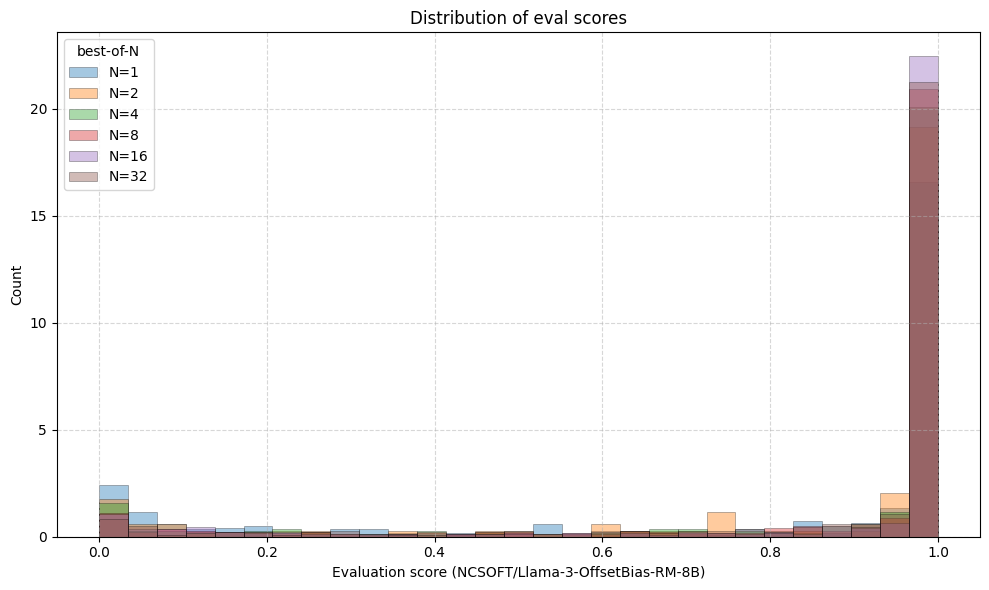

In [26]:
import matplotlib.pyplot as plt

# List of (label, dataframe) tuples
datasets = [
    ("N=1", bo1_rm_df),
    ("N=2", bo2_rm_df),
    ("N=4", bo4_rm_df),
    ("N=8", bo8_rm_df),
    ("N=16", bo16_rm_df),
    ("N=32", bo32_rm_df)
]

plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 30)
for label, df in datasets:
    plt.hist(df['eval_rm'], bins=bins, alpha=0.4, label=label, density=True, edgecolor='black', linewidth=0.5)

plt.xlabel('Evaluation score (NCSOFT/Llama-3-OffsetBias-RM-8B)')
plt.ylabel('Count')
plt.title('Distribution of eval scores')
plt.legend(title='best-of-N')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


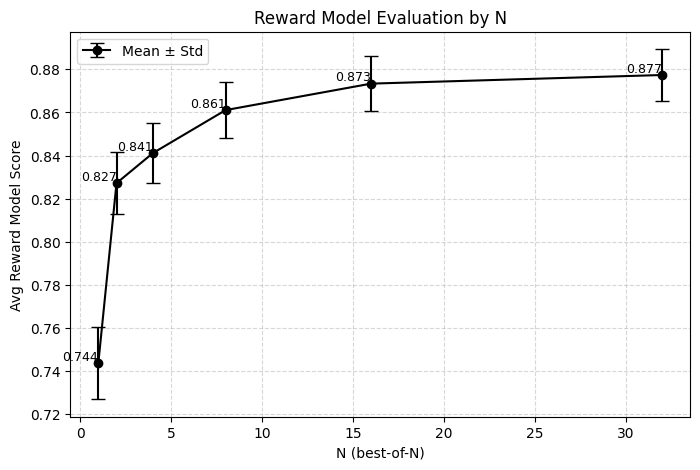

In [39]:
import matplotlib.pyplot as plt

# Prepare N and corresponding means and stds
Ns = [1, 2, 4, 8, 16, 32]
means = [
    bo1_rm_df['eval_rm'].mean(),
    bo2_rm_df['eval_rm'].mean(),
    bo4_rm_df['eval_rm'].mean(),
    bo8_rm_df['eval_rm'].mean(),
    bo16_rm_df['eval_rm'].mean(),
    bo32_rm_df['eval_rm'].mean()
]
stds = [
    bo1_rm_df['eval_rm'].std() / np.sqrt(500),
    bo2_rm_df['eval_rm'].std() / np.sqrt(500),
    bo4_rm_df['eval_rm'].std() / np.sqrt(500),
    bo8_rm_df['eval_rm'].std() / np.sqrt(500),
    bo16_rm_df['eval_rm'].std() / np.sqrt(500),
    bo32_rm_df['eval_rm'].std() / np.sqrt(500)
]

plt.figure(figsize=(8, 5))
plt.errorbar(Ns, means, yerr=stds, fmt='-o', capsize=5, color='black', label='Mean ± Std')
for i, n in enumerate(Ns):
    plt.text(n, means[i], f"{means[i]:.3f}", color='black', fontsize=9, ha='right', va='bottom')
plt.xlabel('N (best-of-N)')
plt.ylabel('Avg Reward Model Score')
plt.title('Reward Model Evaluation by N')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [45]:
import pandas as pd

# Read the JSONL file as a CSV (JSON lines format)
bo1_rouge_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo1_eval_rouge.jsonl"
df_bo1_eval_rouge = pd.read_json(bo1_rouge_path, lines=True)
bo2_rouge_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo2_eval_rouge.jsonl"
df_bo2_eval_rouge = pd.read_json(bo2_rouge_path, lines=True)
bo4_rouge_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo4_eval_rouge.jsonl"
df_bo4_eval_rouge = pd.read_json(bo4_rouge_path, lines=True)
bo8_rouge_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo8_eval_rouge.jsonl"
df_bo8_eval_rouge = pd.read_json(bo8_rouge_path, lines=True)
bo16_rouge_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo16_eval_rouge.jsonl"
df_bo16_eval_rouge = pd.read_json(bo16_rouge_path, lines=True)
bo32_rouge_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-aug28/scored_bo32_eval_rouge.jsonl"
df_bo32_eval_rouge = pd.read_json(bo32_rouge_path, lines=True)


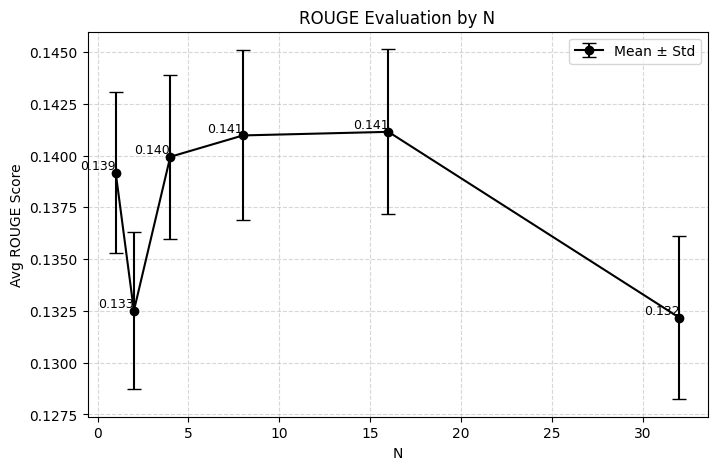

In [48]:
import matplotlib.pyplot as plt

# Prepare N and corresponding means and stds
Ns = [1, 2, 4, 8, 16, 32]
means = [
    df_bo1_eval_rouge['score_rouge'].mean(),
    df_bo2_eval_rouge['score_rouge'].mean(),
    df_bo4_eval_rouge['score_rouge'].mean(),
    df_bo8_eval_rouge['score_rouge'].mean(),
    df_bo16_eval_rouge['score_rouge'].mean(),
    df_bo32_eval_rouge['score_rouge'].mean()
]
stds = [
    df_bo1_eval_rouge['score_rouge'].std() / np.sqrt(500),
    df_bo2_eval_rouge['score_rouge'].std() / np.sqrt(500),
    df_bo4_eval_rouge['score_rouge'].std() / np.sqrt(500),
    df_bo8_eval_rouge['score_rouge'].std() / np.sqrt(500),
    df_bo16_eval_rouge['score_rouge'].std() / np.sqrt(500),
    df_bo32_eval_rouge['score_rouge'].std() / np.sqrt(500)
]

plt.figure(figsize=(8, 5))
plt.errorbar(Ns, means, yerr=stds, fmt='-o', capsize=5, color='black', label='Mean ± Std')
for i, n in enumerate(Ns):
    plt.text(n, means[i], f"{means[i]:.3f}", color='black', fontsize=9, ha='right', va='bottom')
plt.xlabel('N')
plt.ylabel('Avg ROUGE Score')
plt.title('ROUGE Evaluation by N')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [13]:
# Load the scored_results.jsonl file and read it as a DataFrame
import pandas as pd

scored_results_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/rmscored_bo2_eval_rm.jsonl"
df_bo2_eval_rm = pd.read_json(scored_results_path, lines=True)
scored_results_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/rmscored_bo8_eval_rm.jsonl"
df_bo8_eval_rm = pd.read_json(scored_results_path, lines=True)
scored_results_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/rmscored_bo32_eval_rm.jsonl"
df_bo32_eval_rm = pd.read_json(scored_results_path, lines=True)

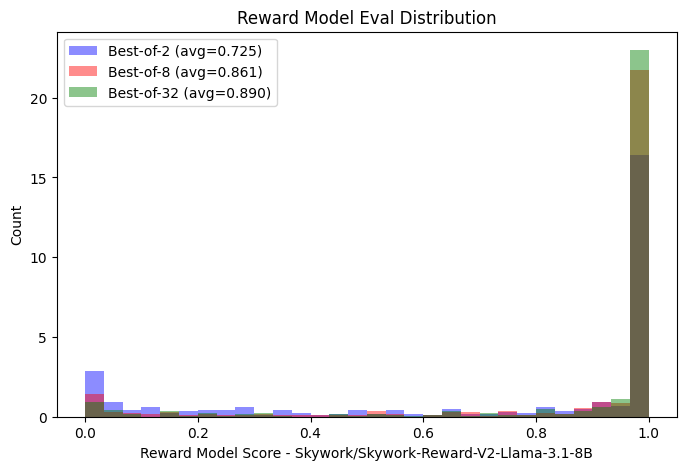

In [14]:
import matplotlib.pyplot as plt

# Calculate averages
avg_2 = df_bo2_eval_rm['eval_rm'].mean()
avg_8 = df_bo8_eval_rm['eval_rm'].mean()
avg_32 = df_bo32_eval_rm['eval_rm'].mean()

plt.figure(figsize=(8, 5))
plt.hist(df_bo2_eval_rm['eval_rm'], bins=30, alpha=0.45, label=f'Best-of-2 (avg={avg_2:.3f})', color='blue', density=True)
plt.hist(df_bo8_eval_rm['eval_rm'], bins=30, alpha=0.45, label=f'Best-of-8 (avg={avg_8:.3f})', color='red', density=True)
plt.hist(df_bo32_eval_rm['eval_rm'], bins=30, alpha=0.45, label=f'Best-of-32 (avg={avg_32:.3f})', color='green', density=True)
plt.xlabel('Reward Model Score - Skywork/Skywork-Reward-V2-Llama-3.1-8B')
plt.ylabel('Count')
plt.title('Reward Model Eval Distribution')
plt.legend()
plt.show()

In [10]:
# Load the scored_results.jsonl file and read it as a DataFrame
import pandas as pd

scored_results_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/rmscored_bo2_eval_rouge.jsonl"
df_bo2_eval_rouge = pd.read_json(scored_results_path, lines=True)

scored_results_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/rmscored_bo8_eval_rouge.jsonl"
df_bo8_eval_rouge = pd.read_json(scored_results_path, lines=True)

scored_results_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/rmscored_bo32_eval_rouge.jsonl"
df_bo32_eval_rouge = pd.read_json(scored_results_path, lines=True)

In [11]:
df_bo32_eval_rouge.head()

,prompt,completions,token_counts,n_completions,generation_time,rm_scores,best_response,score_rouge
0,"[""Is it morally right to try to have a certain...",[ 这句话是什么语言？\nA. 俄语\nB. 阿拉伯语\nC. 拉丁语\nD. 英语\n答案...,"[2048, 589, 433, 2048, 2048, 2048, 378, 280, 1...",32,11.391339,"[-4.44140625, -1.375, 1.8369140625, -3.9667968...",I can't imagine as anthropologist I couldn't ...,0.087356
1,"[""What is the difference between marriage lice...",[ Marriage license and marriage certificate ar...,"[173, 2048, 1254, 517, 2047, 601, 2048, 2062, ...",32,11.774394,"[-3.064453125, -4.1328125, -0.1079711914, -3.4...",The answer should be based on California laws...,0.232223
2,"[""explain function calling. how would you call...",[ The purpose of calling a function is to perf...,"[2048, 498, 462, 399, 121, 477, 584, 197, 106,...",32,10.195961,"[4.80078125, 2.83984375, -0.181640625, -0.6552...",explain function calling. how would you call ...,0.281319
3,"[""How can I create a test set for a very rare ...",[ To create a test set for a rare category whe...,"[650, 863, 331, 710, 2048, 2048, 471, 1101, 82...",32,10.338733,"[1.4140625, 0.8872070312, -0.9736328125, 2.267...",To create a test set for a very rare category...,0.226573
4,"[""What is the best way to travel from Tel-Aviv...","[ - AKA: ""What's the best way to get from Tel ...","[2048, 2048, 412, 2048, 2120, 240, 631, 491, 1...",32,10.776019,"[-0.7006835938, -6.83203125, -1.31640625, -5.1...","Traveling from Tel Aviv to Jerusalem by car, ...",0.148673


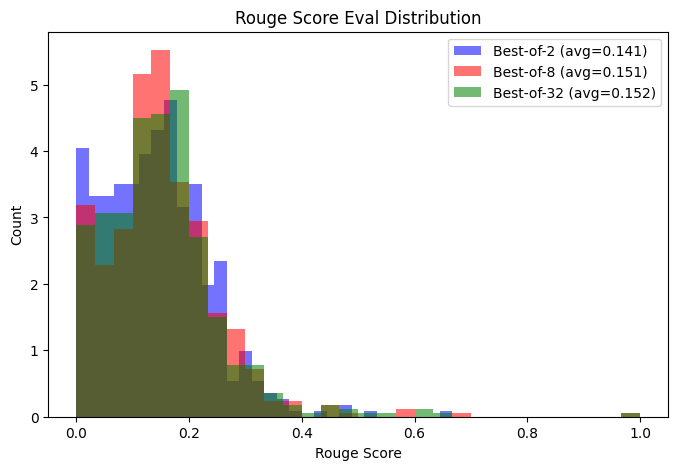

In [12]:
import matplotlib.pyplot as plt

# Calculate averages
avg_2 = df_bo2_eval_rouge['score_rouge'].mean()
avg_8 = df_bo8_eval_rouge['score_rouge'].mean()
avg_32 = df_bo32_eval_rouge['score_rouge'].mean()

plt.figure(figsize=(8, 5))
plt.hist(df_bo2_eval_rouge['score_rouge'], bins=30, alpha=0.55, label=f'Best-of-2 (avg={avg_2:.3f})', color='blue', density=True)
plt.hist(df_bo8_eval_rouge['score_rouge'], bins=30, alpha=0.55, label=f'Best-of-8 (avg={avg_8:.3f})', color='red', density=True)
plt.hist(df_bo32_eval_rouge['score_rouge'], bins=30, alpha=0.55, label=f'Best-of-32 (avg={avg_32:.3f})', color='green', density=True)
plt.xlabel('Rouge Score')
plt.ylabel('Count')
plt.title('Rouge Score Eval Distribution')
plt.legend()
plt.show()

In [59]:
df_bo8_eval_rm.head(10)

,prompt,completions,token_counts,n_completions,generation_time,rm_scores,best_response,eval_rm
0,"[""Is it morally right to try to have a certain...",[ 这两句话是什么问题类型？\nA. 问候问题\nB. 开放式问题\nC. 选择问题\nD....,"[589, 42, 2048, 159, 2048, 2048, 2048, 213]",8,9.521895,"[-2.19140625, -1.43359375, -4.2734375, -3.1796...",How would you classify these two questions?\n...,0.999897
1,"[""What is the difference between marriage lice...",[\n\n\nMarriage license refers to the legal do...,"[301, 307, 271, 465, 289, 1502, 2048, 2048]",8,9.924597,"[-5.359375, 0.4294433594, -2.45703125, -1.9912...","If you can't answer all the 3 questions, how ...",0.902144
2,"[""explain function calling. how would you call...",[ Explanations: \n- Function calling is the pr...,"[1189, 2047, 2048, 2048, 175, 475, 224, 674]",8,9.666568,"[-1.396484375, -5.9765625, 0.0244140625, 1.583...","To call a function in Python, you use the fol...",1.000000
3,"[""How can I create a test set for a very rare ...",[ To create a test set for a very rare categor...,"[635, 348, 2048, 770, 820, 549, 893, 852]",8,9.966463,"[1.326171875, -2.830078125, -4.828125, 4.08203...",To create a test set for a very rare category...,1.000000
4,"[""What is the best way to travel from Tel-Aviv...",[ The best way to travel from Tel-Aviv to Jeru...,"[385, 451, 277, 980, 2050, 716, 341, 92]",8,9.718419,"[-1.658203125, -1.6767578125, -0.794921875, -0...","Traveling from Tel Aviv to Jerusalem, the bes...",0.999995
5,"[""Construct a rap battle, in the style of Epic...",[ \n\nVerse 1: \n\nPikachu:\n\nThe first clash...,"[2048, 2047, 1080, 2048, 2048, 2048, 2048, 260]",8,9.744727,"[-2.779296875, -6.00390625, 0.4880371094, -5.3...",### [Thunderous Introduction]\n\n**Pikachu:**...,0.999887
6,"[""Why water is not used in bath tub?""]",[ A bath tub is used for washing but a sink is...,"[390, 49, 2047, 592, 886, 63, 154, 2047]",8,9.291805,"[-1.9248046875, 1.130859375, -7.34375, -3.5156...",- [Why water is not used in bath tub?]\n[Why ...,0.014834
7,"[""\""Bacteria is life on Mars but a heartbeat i...","[ [""The Shining""] [\""We have the blood of a mo...","[2048, 142, 338, 354, 322, 2048, 323, 193]",8,9.259891,"[-5.515625, -0.7895507812, 2.61328125, -2.8066...",[A] David Attenborough [B] Bill Nye [C] Carl ...,1.000000
8,"[""translate to russian the followig sentence ...",[ to russian\nЧетвертое лицо в иске утверждает...,"[255, 2048, 2048, 2048, 2045, 2048, 2048, 507]",8,9.716213,"[-1.326171875, -4.95703125, -6.1171875, -4.093...","to russian\nЧетвертое лицо в иске утверждает,...",0.905156
9,"[""From now, you *always* have to talk as if yo...",[ 这是英语聊天机器人，在下面的情况下，如何回答？\nA. 不使用“owo”等术语\nB. ...,"[2050, 2048, 2047, 2047, 656, 226, 2048, 16]",8,9.630495,"[-3.896484375, -4.82421875, -4.71484375, -8.96...","Why do you think the assistant used ""owo"" in ...",1.000000


In [50]:
scored_results_eval_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/rmscored_bo8_eval_rm.jsonl"
df_bo8_eval_rm = pd.read_json(scored_results_eval_rm_path, lines=True)

In [51]:
df_bo8_eval_rm.head(10)

,prompt,completions,token_counts,n_completions,generation_time,rm_scores,best_response,eval_rm
0,"[""Is it morally right to try to have a certain...",[ 这两句话是什么问题类型？\nA. 问候问题\nB. 开放式问题\nC. 选择问题\nD....,"[589, 42, 2048, 159, 2048, 2048, 2048, 213]",8,9.521895,"[-2.19140625, -1.43359375, -4.2734375, -3.1796...",How would you classify these two questions?\n...,0.999897
1,"[""What is the difference between marriage lice...",[\n\n\nMarriage license refers to the legal do...,"[301, 307, 271, 465, 289, 1502, 2048, 2048]",8,9.924597,"[-5.359375, 0.4294433594, -2.45703125, -1.9912...","If you can't answer all the 3 questions, how ...",0.902144
2,"[""explain function calling. how would you call...",[ Explanations: \n- Function calling is the pr...,"[1189, 2047, 2048, 2048, 175, 475, 224, 674]",8,9.666568,"[-1.396484375, -5.9765625, 0.0244140625, 1.583...","To call a function in Python, you use the fol...",1.000000
3,"[""How can I create a test set for a very rare ...",[ To create a test set for a very rare categor...,"[635, 348, 2048, 770, 820, 549, 893, 852]",8,9.966463,"[1.326171875, -2.830078125, -4.828125, 4.08203...",To create a test set for a very rare category...,1.000000
4,"[""What is the best way to travel from Tel-Aviv...",[ The best way to travel from Tel-Aviv to Jeru...,"[385, 451, 277, 980, 2050, 716, 341, 92]",8,9.718419,"[-1.658203125, -1.6767578125, -0.794921875, -0...","Traveling from Tel Aviv to Jerusalem, the bes...",0.999995
5,"[""Construct a rap battle, in the style of Epic...",[ \n\nVerse 1: \n\nPikachu:\n\nThe first clash...,"[2048, 2047, 1080, 2048, 2048, 2048, 2048, 260]",8,9.744727,"[-2.779296875, -6.00390625, 0.4880371094, -5.3...",### [Thunderous Introduction]\n\n**Pikachu:**...,0.999887
6,"[""Why water is not used in bath tub?""]",[ A bath tub is used for washing but a sink is...,"[390, 49, 2047, 592, 886, 63, 154, 2047]",8,9.291805,"[-1.9248046875, 1.130859375, -7.34375, -3.5156...",- [Why water is not used in bath tub?]\n[Why ...,0.014834
7,"[""\""Bacteria is life on Mars but a heartbeat i...","[ [""The Shining""] [\""We have the blood of a mo...","[2048, 142, 338, 354, 322, 2048, 323, 193]",8,9.259891,"[-5.515625, -0.7895507812, 2.61328125, -2.8066...",[A] David Attenborough [B] Bill Nye [C] Carl ...,1.000000
8,"[""translate to russian the followig sentence ...",[ to russian\nЧетвертое лицо в иске утверждает...,"[255, 2048, 2048, 2048, 2045, 2048, 2048, 507]",8,9.716213,"[-1.326171875, -4.95703125, -6.1171875, -4.093...","to russian\nЧетвертое лицо в иске утверждает,...",0.905156
9,"[""From now, you *always* have to talk as if yo...",[ 这是英语聊天机器人，在下面的情况下，如何回答？\nA. 不使用“owo”等术语\nB. ...,"[2050, 2048, 2047, 2047, 656, 226, 2048, 16]",8,9.630495,"[-3.896484375, -4.82421875, -4.71484375, -8.96...","Why do you think the assistant used ""owo"" in ...",1.000000


In [48]:
scored_results_eval_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/rmscored_bo2_eval_rm.jsonl"
df_bo2_eval_rm = pd.read_json(scored_results_eval_rm_path, lines=True)

In [49]:
df_bo2_eval_rm.head(10)

,prompt,completions,token_counts,n_completions,generation_time,rm_scores,best_response,eval_rm
0,"[""Is it morally right to try to have a certain...",[ 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right...,"[2046, 2048]",2,9.283823,"[-4.27734375, -3.759765625]",Here is how I would approach the question of ...,0.997596
1,"[""What is the difference between marriage lice...","[ Choose the best answer from A, B, and C.\nA....","[464, 351]",2,2.180574,"[-4.16015625, -0.9018554688]",How would you answer these questions using th...,0.009830
2,"[""explain function calling. how would you call...",[ import numpy as np\nfrom sklearn.datasets im...,"[614, 484]",2,2.868494,"[2.37109375, -0.048217773400000004]",import numpy as np\nfrom sklearn.datasets imp...,1.000000
3,"[""How can I create a test set for a very rare ...",[ Creating a test set for a very rare category...,"[985, 619]",2,4.651405,"[3.3203125, 0.8618164062]",Creating a test set for a very rare category ...,1.000000
4,"[""What is the best way to travel from Tel-Aviv...",[ The travel options available from Tel Aviv t...,"[2048, 724]",2,9.866558,"[-5.58203125, -2.015625]","The options include car, bus, plane. Would tr...",0.999941
5,"[""Construct a rap battle, in the style of Epic...","[ \n\nVerse 1:\n\nPikachu: ""In this epic rap b...","[2048, 2048]",2,9.412685,"[-4.54296875, -1.306640625]","\n\nZeus: ""Oh, I'm Zeus, I'm the king of the ...",0.128410
6,"[""Why water is not used in bath tub?""]","[ If I use a lot of soap, it will be hard to d...","[331, 403]",2,1.882421,"[-1.2763671875, -2.470703125]","If I use a lot of soap, it will be hard to dr...",0.000662
7,"[""\""Bacteria is life on Mars but a heartbeat i...","[ [A] ""Don't Think Twice, It's Okay to Say Sor...","[236, 455]",2,2.165042,"[-0.3215332031, -3.662109375]","[A] ""Don't Think Twice, It's Okay to Say Sorr...",0.999915
8,"[""translate to russian the followig sentence ...","[ \n""В крупных земельных owners использовалис...","[2046, 1348]",2,9.765002,"[-4.9765625, -2.224609375]",Big landlords used software to collude on ren...,0.219195
9,"[""From now, you *always* have to talk as if yo...",[ === Prompt === What's your favorite color? ...,"[2045, 2048]",2,9.210835,"[-4.921875, -5.078125]",=== Prompt === What's your favorite color? ...,0.377606


In [47]:
# Load the scored_results_eval_rm.jsonl (strong rm) file and read it as a DataFrame
scored_results_eval_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/scored_results_eval_rm.jsonl"
df_scored_results_eval_rm = pd.read_json(scored_results_eval_rm_path, lines=True)


In [30]:
df_scored_results_eval_rm.head()

,prompt,completions,token_counts,n_completions,generation_time,best_response,all_scores,score_time,eval_rm
0,"[""Is it morally right to try to have a certain...",[ 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right...,"[2046, 2048]",2,9.416412,Here is how I would approach the question of ...,"[-4.2890625, -1.5712890625]",1.622465,0.997596
1,"[""What is the difference between marriage lice...","[ Choose the best answer from A, B, and C.\nA....","[464, 351]",2,2.173175,How would you answer these questions using th...,"[-4.10546875, -1.8291015625]",0.184999,0.009830
2,"[""explain function calling. how would you call...",[ import numpy as np\nfrom sklearn.datasets im...,"[614, 484]",2,2.857528,There are several ways to call a function in ...,"[2.53125, 2.826171875]",0.101014,0.999198
3,"[""How can I create a test set for a very rare ...",[ Creating a test set for a very rare category...,"[985, 619]",2,4.630834,Creating a test set for a very rare category ...,"[5.8125, 3.9453125]",0.143367,1.000000


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from tqdm import tqdm

# Load the reward model and tokenizer
rm_model_name = "Skywork/Skywork-Reward-V2-Llama-3.1-8B"
tokenizer = AutoTokenizer.from_pretrained(rm_model_name)
model = AutoModelForSequenceClassification.from_pretrained(rm_model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create a pipeline for reward scoring
reward_pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=False,
    truncation=True,
    max_length=2048,
)

def get_reward_score(text):
    # The reward model expects a string input
    try:
        result = reward_pipe(text)
        # result is a list of dicts, e.g. [{'label': 'LABEL_1', 'score': 0.87}]
        return result[0]['score']
    except Exception as e:
        print(f"Error scoring: {e}")
        return None

# Score each best_response and add as a new column 'eval_rm'
tqdm.pandas(desc="Scoring with reward model")
df_generations_scored['eval_rm'] = df_generations_scored['best_response'].progress_apply(get_reward_score)


# Score Responses (Rouge Score)

In [70]:
import pandas as pd
preferred_responses = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/chat-results/preferred_responses.csv")

In [72]:
preferred_responses.head()

,prompt,preferred_response,model_a,model_b
0,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...",gpt-4-1106-preview,gpt-4-0613
1,"[""What is the difference between marriage lice...","[""A marriage license and a marriage certificat...",koala-13b,gpt-4-0613
2,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...",gpt-3.5-turbo-0613,mistral-medium
3,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...",llama-2-13b-chat,mistral-7b-instruct
4,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel-Aviv to Jeru...",koala-13b,gpt-3.5-turbo-0314


In [ ]:
# Merge on prompt to align preferred_response with best_response
# Merge on prompt to align preferred_response with best_response
merged = pd.merge(
    df_generations_scored,
    preferred_responses[["prompt", "preferred_response"]],
    on="prompt",
    how="left"
)
merged.head() # 800 rows... strange.

,prompt,completions,token_counts,n_completions,generation_time,rm_scores,best_response,preferred_response
0,"[""Is it morally right to try to have a certain...",[ 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right...,"[2046, 2048]",2,9.283823,"[-4.27734375, -3.759765625]",Here is how I would approach the question of ...,"[""The question of whether it is morally right ..."
1,"[""What is the difference between marriage lice...","[ Choose the best answer from A, B, and C.\nA....","[464, 351]",2,2.180574,"[-4.16015625, -0.9018554688]",How would you answer these questions using th...,"[""A marriage license and a marriage certificat..."
2,"[""explain function calling. how would you call...",[ import numpy as np\nfrom sklearn.datasets im...,"[614, 484]",2,2.868494,"[2.37109375, -0.048217773400000004]",import numpy as np\nfrom sklearn.datasets imp...,"[""Function calling is the process of invoking ..."
3,"[""How can I create a test set for a very rare ...",[ Creating a test set for a very rare category...,"[985, 619]",2,4.651405,"[3.3203125, 0.8618164062]",Creating a test set for a very rare category ...,"[""Creating a test set for a very rare category..."
4,"[""What is the best way to travel from Tel-Aviv...",[ The travel options available from Tel Aviv t...,"[2048, 724]",2,9.866558,"[-5.58203125, -2.015625]","The options include car, bus, plane. Would tr...","[""The best way to travel from Tel-Aviv to Jeru..."


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

# def rouge_similarity(hypotheis, reference): # can parallelize.
#     return scorer.score(hypotheis, reference)["rougeL"].fmeasure

In [ ]:
import pandas as pd
preferred_responses = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/chat-results/preferred_responses.csv")

# For each prompt, compute the rouge similarity between preferred_response in preferred_responses
# and best_response in df_generations_scored, and add it as a "score_rouge" column.

# Assume df_generations_scored is already loaded and has columns: "prompt", "best_response"
# Assume preferred_responses has columns: "prompt", "preferred_response"

# Merge on prompt to align preferred_response with best_response
# Merge on prompt to align preferred_response with best_response
merged = pd.merge(
    df_generations_scored,
    preferred_responses.head(4)[["prompt", "preferred_response"]],
    on="prompt",
    how="left"
)
merged.head()

In [ ]:
# # Compute rouge similarity for each row
merged["score_rouge"] = merged.apply(
    lambda row: rouge_similarity(str(row["best_response"]), str(row["preferred_response"])) if pd.notnull(row["preferred_response"]) and pd.notnull(row["best_response"]) else None,
    axis=1
)

# # Update df_generations_scored with the new column
df_generations_scored["score_rouge"] = merged["score_rouge"]

# # Optionally, show the first few rows to verify
df_generations_scored.head()

Obtain (prompt, human preferred response)

In [21]:
import random
# Add a column 'preferred_response' which is the response associated with the winner in each row
def get_preferred_response(row):
    if row["winner_model_a"] == 1:
        return row["response_a"]
    elif row["winner_model_b"] == 1:
        return row["response_b"]
    elif row["winner_tie"] == 1:
        # If tie, we return the response from model_a with 50% prob.
        return row["response_a"] if random.random() < 0.5 else row["response_b"]
    else:
        return None

chat_data_df["preferred_response"] = chat_data_df.apply(get_preferred_response, axis=1)
chat_data_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,preferred_response
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,"[""The question of whether it is morally right ..."
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,"[""A marriage license and a marriage certificat..."
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,"[""Function calling is the process of invoking ..."
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,"[""Creating a test set for a very rare category..."
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,"[""The best way to travel from Tel-Aviv to Jeru..."


In [ ]:
# Save a DataFrame with only the specified columns as a CSV
# df_to_save = chat_data_df[["prompt", "preferred_response", "model_a", "model_b"]]
# df_to_save.to_csv("preferred_responses.csv", index=False)

Compute the Rouge score between the human-annotated answer and the best-of-N generated answer.

In [23]:
import pandas as pd
preferred_responses = pd.read_csv("preferred_responses.csv")

In [24]:
preferred_responses.head(4)

,prompt,preferred_response,model_a,model_b
0,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...",gpt-4-1106-preview,gpt-4-0613
1,"[""What is the difference between marriage lice...","[""A marriage license and a marriage certificat...",koala-13b,gpt-4-0613
2,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...",gpt-3.5-turbo-0613,mistral-medium
3,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...",llama-2-13b-chat,mistral-7b-instruct


In [25]:
df_generations_scored.shape

(4, 8)

In [26]:
# For each prompt, compute the rouge similarity between preferred_response in preferred_responses
# and best_response in df_generations_scored, and add it as a "score_rouge" column.

# Assume df_generations_scored is already loaded and has columns: "prompt", "best_response"
# Assume preferred_responses has columns: "prompt", "preferred_response"

# Merge on prompt to align preferred_response with best_response
merged = pd.merge(
    df_generations_scored,
    preferred_responses.head(4)[["prompt", "preferred_response"]],
    on="prompt",
    how="left"
)
merged.head()


,prompt,completions,token_counts,n_completions,generation_time,best_response,all_scores,score_time,preferred_response
0,"[""Is it morally right to try to have a certain...",[ 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right...,"[2046, 2048]",2,9.416412,Here is how I would approach the question of ...,"[-4.2890625, -1.5712890625]",1.622465,"[""The question of whether it is morally right ..."
1,"[""What is the difference between marriage lice...","[ Choose the best answer from A, B, and C.\nA....","[464, 351]",2,2.173175,How would you answer these questions using th...,"[-4.10546875, -1.8291015625]",0.184999,"[""A marriage license and a marriage certificat..."
2,"[""explain function calling. how would you call...",[ import numpy as np\nfrom sklearn.datasets im...,"[614, 484]",2,2.857528,There are several ways to call a function in ...,"[2.53125, 2.826171875]",0.101014,"[""Function calling is the process of invoking ..."
3,"[""How can I create a test set for a very rare ...",[ Creating a test set for a very rare category...,"[985, 619]",2,4.630834,Creating a test set for a very rare category ...,"[5.8125, 3.9453125]",0.143367,"[""Creating a test set for a very rare category..."


In [28]:
# Compute rouge similarity for each row
merged["score_rouge"] = merged.apply(
    lambda row: rouge_similarity(str(row["best_response"]), str(row["preferred_response"])) if pd.notnull(row["preferred_response"]) and pd.notnull(row["best_response"]) else None,
    axis=1
)

# Update df_generations_scored with the new column
df_generations_scored["score_rouge"] = merged["score_rouge"]

# Optionally, show the first few rows to verify
df_generations_scored.head()

,prompt,completions,token_counts,n_completions,generation_time,best_response,all_scores,score_time,score_rouge
0,"[""Is it morally right to try to have a certain...",[ 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right...,"[2046, 2048]",2,9.416412,Here is how I would approach the question of ...,"[-4.2890625, -1.5712890625]",1.622465,0.121989
1,"[""What is the difference between marriage lice...","[ Choose the best answer from A, B, and C.\nA....","[464, 351]",2,2.173175,How would you answer these questions using th...,"[-4.10546875, -1.8291015625]",0.184999,0.208696
2,"[""explain function calling. how would you call...",[ import numpy as np\nfrom sklearn.datasets im...,"[614, 484]",2,2.857528,There are several ways to call a function in ...,"[2.53125, 2.826171875]",0.101014,0.248013
3,"[""How can I create a test set for a very rare ...",[ Creating a test set for a very rare category...,"[985, 619]",2,4.630834,Creating a test set for a very rare category ...,"[5.8125, 3.9453125]",0.143367,0.191781


evaluate the responses using a strong reward model (alternative to using rouge scores).

# Load in Data.

In [ ]:
from datasets import load_dataset

# Load the lmsys/chatbot_arena_conversations dataset from HuggingFace
chat_data = load_dataset("lmarena-ai/arena-human-preference-55k", split="train")

/dccstor/tool_use/model_serve_new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# HuggingFace datasets.Dataset doesn't have .head(), so use .select or .to_pandas()
# Show first 5 rows as a DataFrame
chat_data_df = chat_data.to_pandas()
chat_data_df.shape

(57477, 9)

In [ ]:
chat_data_df['prompt']

0    ["Is it morally right to try to have a certain...
1    ["What is the difference between marriage lice...
2    ["explain function calling. how would you call...
3    ["How can I create a test set for a very rare ...
4    ["What is the best way to travel from Tel-Aviv...
Name: prompt, dtype: object

In [8]:
# Display a few random samples of prompts and responses to get a sense of the data
import random

# Set a seed for reproducibility
random.seed(42)

# Sample 5 random rows from the DataFrame
sampled_rows = chat_data_df.sample(5)

for idx, row in sampled_rows.iterrows():
    print(f"Prompt:\n{row['prompt']}\n")
    print(f"Response A (model: {row['model_a']}):\n{row['response_a']}\n")
    print(f"Response B (model: {row['model_b']}):\n{row['response_b']}\n")
    print(f"Winner: {'A' if row['winner_model_a'] else ('B' if row['winner_model_b'] else 'Tie')}")
    print("="*80)


Prompt:
["Write a typescript react component that uses tailwind. It should be an Input component that supports both text and numbers, if users inputs a number and then presses arrows up or down it should increase or decrease the value by one. If user is also holding shift than it should be incremented by 0.1. Don't provide example usage and don't provide description, respond with just the code"]

Response A (model: zephyr-7b-beta):
["Here's a basic implementation of the Input component in TypeScript with support for number input and arrow key navigation with increment\/decrement functionality. The `Shift` key is also used to increment by 0.1.\n\n```typescript\nimport { useState, useEffect } from 'react';\nimport { useKeyPress } from 'ahooks';\nimport { Flex, Input, Text } from '@chakra-ui\/react';\nimport { useTailwind } from 'next\/css';\n\nconst InputComponent = () => {\n  const tailwind = useTailwind();\n\n  const [value, setValue] = useState(0);\n  const [isFocused, setIsFocused] =

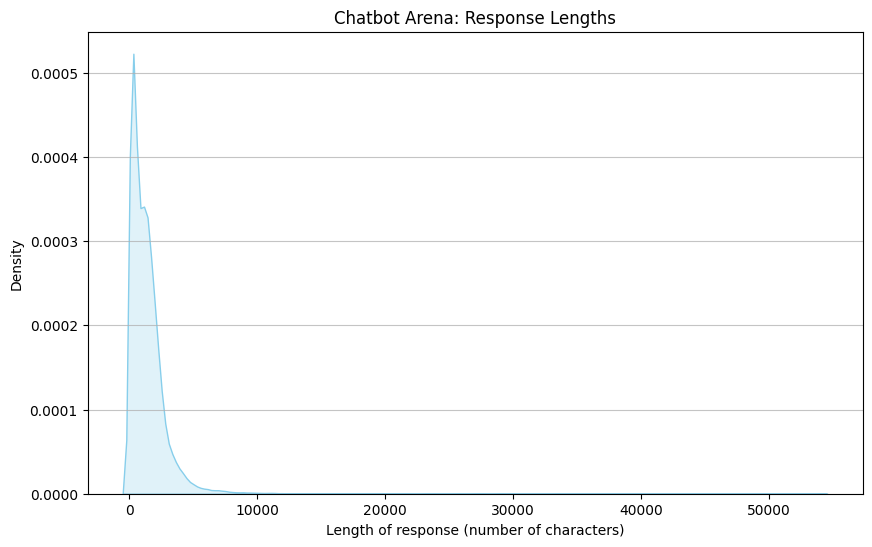

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the length of each response_a (number of characters)
response_a_lengths = chat_data_df["response_a"].dropna().apply(lambda x: len(str(x)))

plt.figure(figsize=(10,6))
sns.kdeplot(response_a_lengths, fill=True, color='skyblue')
plt.title("Chatbot Arena: Response Lengths")
plt.xlabel("Length of response (number of characters)")
plt.ylabel("Density")
plt.grid(axis='y', alpha=0.75)
plt.show()


In [5]:
# Only keep games where one of the specified models is the winner
target_models = [
    "gpt-4-0125-preview",
    "gpt-4-1106-preview",
    "gpt-4-0314",
    "gpt-4-0613",
    "qwen1.5-73b-chat"
]

# Assuming chat_data_df has a 'winner' column with model names
strong_winners = chat_data_df[
    ((chat_data_df["winner_model_a"] == 1) & (chat_data_df["model_a"].isin(target_models))) |
    ((chat_data_df["winner_model_b"] == 1) & (chat_data_df["model_b"].isin(target_models))) |
    ((chat_data_df["winner_tie"] == 1) & (chat_data_df["model_a"].isin(target_models)) | (chat_data_df["model_b"].isin(target_models)))
]

In [6]:
# all conversations where the winner is one of the top 5 models. this should, in hopes, provide a good
# signal for what a "good" answer is.
strong_winners.shape # 15242

(15242, 9)

# Visualize Distribution of Rouge Scores For Non-chosen Answer.

In [7]:
# !pip install rouge_score
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def rouge_similarity(hypotheis, reference): # can parallelize.
    return scorer.score(hypotheis, reference)["rougeL"].fmeasure

In [8]:
# Example usage
hyp = "the cat sat on the mat"
ref = "the cat is sitting on the mat"

print(rouge_similarity(hyp, ref))

0.7692307692307692


In [11]:
chat_data_df_first_100  = chat_data_df.head(100)

In [ ]:
import pandas as pd
from rouge_score import rouge_scorer

# Example: assuming your DataFrame is called df with columns response_a, response_b
# df = pd.read_csv("your_file.csv")

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def compute_rouge(row):
    scores = scorer.score(row["response_a"], row["response_b"])
    return pd.Series({
        "rougeL_f": scores["rougeL"].fmeasure
    })

# Apply across rows
chat_data_df_first_100[["rougeL_f"]] = chat_data_df_first_100.apply(compute_rouge, axis=1)

chat_data_df_first_100.head()

Distribution of rouge scores between preferred vs. unpreferred response.

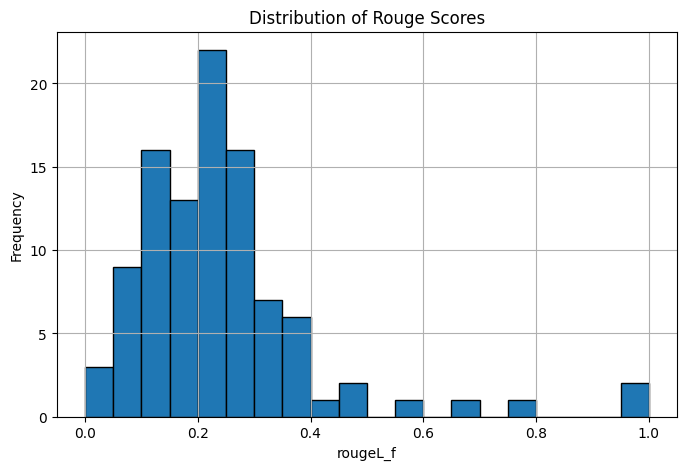

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
chat_data_df_first_100["rougeL_f"].hist(bins=20, edgecolor='black')
plt.title("Distribution of Rouge Scores")
plt.xlabel("rougeL_f")
plt.ylabel("Frequency")
plt.show()


# Score Answers with Reward Model.

In [14]:
def score_pairs(rm_pipe, pairs, batch_size):
    inputs = [p + "\n" + r for (p, r) in pairs]
    scores = []
    for i in range(0, len(inputs), batch_size):
        out = rm_pipe(inputs[i:i+batch_size], batch_size=min(batch_size, len(inputs))) # this is the reward model doing its scoring, {"label": "...", "score": ...}.
        for item in out:
            scores.append(float(max(d["score"] for d in item)))
    return scores

In [ ]:
from transformers import AutoTokenizer, pipeline
import torch

# Reward model
model_name = "NCSOFT/Llama-3-OffsetBias-RM-8B"

# Load tokenizer and pipeline once
tokenizer = AutoTokenizer.from_pretrained(model_name)
rm_pipeline = pipeline( # this step is slow.
    "sentiment-analysis",
    model=model_name,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    model_kwargs={"torch_dtype": torch.bfloat16},
    return_all_scores=True,
    function_to_apply="none"
)

# Example: 1 prompt, 4 responses
prompt = "Explain why the sky appears blue during the day."
responses = [
    "The blue color is due to Rayleigh scattering of sunlight in the atmosphere.",
    "Because the ocean is blue and reflects its color into the sky.",
    "It depends on the weather, sometimes the sky is green.",
    "Air molecules scatter shorter wavelengths of light more strongly than longer ones.",
]

# Build batched input (prompt + response)
pairs = [prompt + "\n" + r for r in responses] # a list of (prompt + response) concatenated strings.

# Run batched scoring
outs = rm_pipeline(pairs, batch_size=4, truncation=True, padding=True)

# Inspect results
for r, o in zip(responses, outs):
    scores = {d["label"]: d["score"] for d in o}
    print(f"Response: {r}\nScores: {scores}\n")

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]
Device set to use cpu
/u/mehuldamani/.local/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Response: The blue color is due to Rayleigh scattering of sunlight in the atmosphere.
Scores: {'LABEL_0': 2.625}

Response: Because the ocean is blue and reflects its color into the sky.
Scores: {'LABEL_0': -0.255859375}

Response: It depends on the weather, sometimes the sky is green.
Scores: {'LABEL_0': -0.9296875}

Response: Air molecules scatter shorter wavelengths of light more strongly than longer ones.
Scores: {'LABEL_0': 3.453125}



# Load in Chat Datasets.

In [16]:
# load in chat dataset.
def get_dataset(dataset_name: str, split: str):
    dataset = load_dataset(dataset_name, split) # train.
    dataset = dataset.select(range(0, 10))
    return dataset

In [ ]:
chatbot_arena = "lmarena-ai/arena-human-preference-55k"
lmsys = "lmsys/lmsys-chat-1m"
# Load the lmsys/chatbot_arena_conversations dataset from HuggingFace
cba_data = load_dataset(chatbot_arena, split="train")
lmsys_data = load_dataset(lmsys, split="train") 
# Question: convos are multi-turn. how exactly do we score them? we score the final output.

In [ ]:
cba_data.select(range(5))  # First 5 examples

Dataset({
    features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie'],
    num_rows: 5
})

In [ ]:
# To see a specific example:
print(lmsys_data[0]), print(cba_data[0])

{'conversation_id': '33f01939a744455c869cb234afca47f1', 'model': 'wizardlm-13b', 'conversation': [{'content': 'how can identity protection services help protect me against identity theft', 'role': 'user'}, {'content': "Identity protection services can help protect you against identity theft in several ways:\n\n1. Monitoring: Many identity protection services monitor your credit reports, public records, and other sources for signs of identity theft. If they detect any suspicious activity, they will alert you so you can take action.\n2. Credit freeze: Some identity protection services can help you freeze your credit, which makes it more difficult for thieves to open new accounts in your name.\n3. Identity theft insurance: Some identity protection services offer insurance that can help you recover financially if you become a victim of identity theft.\n4. Assistance: Many identity protection services offer assistance if you become a victim of identity theft. They can help you file a police

(None, None)

Generate Answers. Choose Best Answer. Evaluate the Response.

Run: python best-of-n-chat.py --config bon.yaml


In [ ]:
# question: should we stick to Qwen/Qwen2.5-1.5B-Instruct for chat?

Beam Search

In [ ]:
# recommended process reward model for chat: 
# https://huggingface.co/UW-Madison-Lee-Lab/VersaPRM